В первом домашнем задании вам предлагается:

* Показать что $D_{KL}(p||q) \ge 0$ для любых $p$ и $q$. Для этого можно воспользоваться [формулой Йенсена](https://en.wikipedia.org/wiki/Jensen%27s_inequality "неравенство Йенсена")
* (дополнительно) Показать, что максимизация правдопобия эквивалентна минимизации $D_{KL}$. 

Ответы впишите на место этой ячейки. Для оформления можно (и нужно) воспользваоться [markdown](https://en.support.wordpress.com/markdown-quick-reference/) и формулами [TEX](https://en.wikibooks.org/wiki/LaTeX/Mathematics).

$D_{KL}(p||q) = -\displaystyle\sum_{i=1}^{N} p_i \log \bigg( \frac{q_i}{p_i} \bigg)$

Применяя неравенство Йенсена для вогнутой функции $\log(x)$:
$\varphi \bigg( \frac{\sum a_i x_i}{\sum a_i}\bigg) \geq \frac{\sum a_i \varphi (x_i)}{\sum a_i}.(1)$

$-\displaystyle\sum_{i=1}^{N} p_i \log \bigg( \frac{q_i}{p_i} \bigg) 
\geq - \log \displaystyle \frac{\sum p_i\bigg( \frac{q_i}{p_i} \bigg)}{\sum p_i} (1)$
,учитывая: $\sum p_i \equiv 1$, $\sum q_i \equiv 1$

Получаем:
$(1) = - \log \big( \sum q_i \big) = - \log(1) = 0$, $\implies D_{KL}(p||q) \geq 0, \forall p_i, q_i$


Буквально три-четыре года назад для того, чтобы обучить нейронную сеть было необходимо вручную вычислить градиент функции потерь. Затем, обычно, правильность решения проверялась численно. После появления фреймворков вроде Theano и TF это стало необязательным, благодаря чему исследователи и инженеры могут проводить свои эксперименты значительно быстрее. В данной работе мы посчитаем и проверим градиенты для линейных моделей, рассмотренных на первой лекции; а так же в явном виде реализуем алгоритм оптимизации.      

In [1]:
#!pip install tensorflow
import numpy as np
from keras.datasets import cifar10
from random import randrange
import time

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 12) # set default size of plots

Для обучения мы будем использовать датасет CIFAR-10, состоящий из 60000 цветных изображений размера 32x32, разбитых на 10 классов, по 6000 изображений на класс. Обучающая выборка состоит из 50000 изображений, а тестовая -- из 10000. 

In [8]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Визуализируем классы

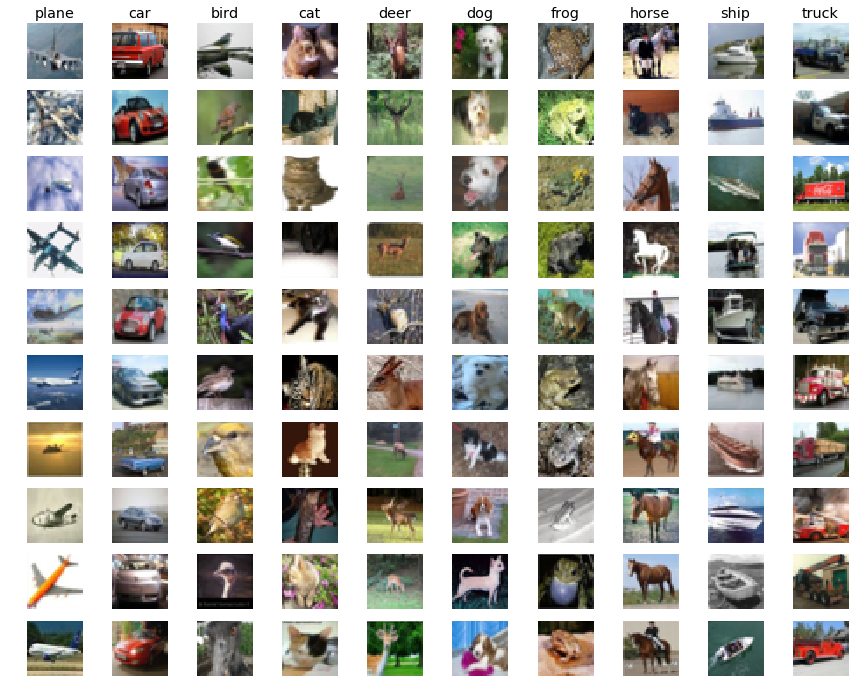

In [9]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(x_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [10]:
# Preprocessing: преобразуем изображения к плоскому виду
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))

# Печатаем размерности, чтобы проверить что мы не ошиблись
print('Training data shape: ', x_train.shape)
print('Test data shape: ', x_test.shape)

Training data shape:  (50000, 3072)
Test data shape:  (10000, 3072)


[ 130.71074  136.05614  132.5538   130.14036  135.44238  131.85358
  131.05044  136.24616  132.58144  131.56886]


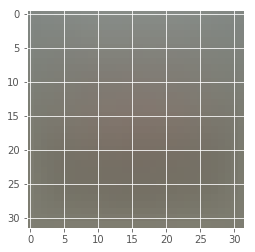

In [11]:
# Preprocessing: вычитаем среднее
# 1: Находим среднее изображение
mean_image = np.mean(x_train, axis=0)
print(mean_image[:10]) # для проверки напечаем несколько элементов
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # визуализируем полученное среднее
plt.show()

In [12]:
# 2: вычитаем среднее из изображений обучающей и тестовых выборок
x_train = x_train - mean_image
x_test = x_test - mean_image

In [13]:
# 3: Добавляем новую компоненту отвечающую за сдвиг (bias trick)
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])

**Задача 1:** Далее следует функция svm_loss, которую вам предстоит дописать.

In [20]:
def svm_loss(W, X, y, reg):
    """
    SVM loss function
    Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    delta = 2
    loss = 0
    dW = np.zeros(W.shape)

    (N,n) = X.shape
    
    # get scores for each class
    wx = np.array([np.dot(W,x) for x in X])
    
    for i in range(N) :
        y_i = y[i]
        x_i = X[i]        
        wx_i = wx[i]
        #print('wx: %a, wx: %a' % (wx_i.shape, wx_i))
        
        # sum loss for each component
        dy = - wx_i[y_i] + delta
        for j,wx_ij in enumerate(wx_i) :
            if j == y_i:
                continue
            L_ij = max(0, wx_ij + dy)
            if L_ij > 0 :
                dW[j] += x_i
                dW[y_i] -= x_i
            loss += L_ij    
    
    loss = loss / N + reg * np.dot(W.flat,W.flat)
    dW = dW / N + 2 * reg * W
    
    #############################################################################
    # TODO:                                                                     #
    # Compute the gradient of the loss function and store it dW.                #
    # Rather that first computing the loss and then computing the derivative,   #
    # it may be simpler to compute the derivative at the same time that the     #
    # loss is being computed. As a result you may need to modify some of the    #
    # code above to compute the gradient.                                       #
    #############################################################################
    
    return loss, dW

In [21]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001
REG = 5e-5
print(x_test.shape)
loss_t, grad_t = svm_loss(W, x_test, y_test, REG)
print('loss: %f, dW: %a ' % (loss_t, grad_t.shape ))


(10000, 3073)
loss: 18.313782, dW: (10, 3073) 


In [22]:
#При помощи этой функции можно проверить градиент численно 
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """
    h = 1e-5

    x.shape
    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        x[ix] += h # increment by h
        fxph = f(x) # evaluate f(x + h)
        x[ix] -= 2 * h # increment by h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] += h # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
        print ('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

In [24]:
# Вычисляем значение функции потерь и её градиент для W.
loss, grad = svm_loss(W, x_test, y_test, 0.0)

# Проверяем численно
f = lambda w: svm_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print('now with REG=%f', 5e1)
# Проверяем численно, используя регуляризацию.
# Вы ведь не забыли реализовать регуляризацию, правда? 
loss, grad = svm_loss(W, x_test, y_test, 5e1)
f = lambda w: svm_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -6.307748 analytic: -6.307748, relative error: 5.163089e-10
numerical: 3.699731 analytic: 3.699731, relative error: 4.159866e-10
numerical: -6.281686 analytic: -6.281686, relative error: 4.088110e-10
numerical: 15.928000 analytic: 15.928000, relative error: 1.898827e-10
numerical: 6.337377 analytic: 6.337377, relative error: 3.624853e-10
numerical: 15.058169 analytic: 15.058169, relative error: 7.499739e-11
numerical: -6.671795 analytic: -6.671795, relative error: 3.965842e-10
numerical: -9.996648 analytic: -9.996648, relative error: 2.293850e-11
numerical: 15.245591 analytic: 15.245591, relative error: 9.401038e-11
numerical: -2.217527 analytic: -2.217527, relative error: 1.441292e-09
now with REG=%f 50.0
numerical: -9.142346 analytic: -9.142346, relative error: 6.706025e-10
numerical: -0.790131 analytic: -0.790131, relative error: 1.258846e-09
numerical: -5.990934 analytic: -5.990934, relative error: 1.081991e-10
numerical: 17.996967 analytic: 17.996967, relative error: 2.

**Задача 2:** Реализуйте методы класса SVM. Для тренировки используйте градиентный спуск.

In [25]:
class SVM():
    def __init__(self, batch_count):
        self.W = np.random.randn(10, 3073) * 0.0001 
        self.Iters = 0
        self.batch_count=batch_count
    def train(self, x_train, y_train, num_iters=1000, learning_rate=1e-7, reg=2.5e4,
                       verbose=True):
        #Здесь (на месте заглушки) впишите релаизацию градиентного спуска, используя функцию потерь, которую вы определелили выше.
        #Если обучение проходит слишком медленно, возможно необходимо что-то улучшить?
        loss_history = []
        (N,n) = x_train.shape
        for it in range(num_iters):
            # build batch
            ib = [randrange(N) for k in range(self.batch_count)]
            
            b_x = np.array(x_train[ib])
            b_y = np.array(y_train[ib])
            
            loss, grad = svm_loss(self.W, b_x, b_y, reg)
            loss_history.append(loss)
            self.W -= grad * learning_rate;
            self.Iters+=1;
            if verbose :
                print(it, loss)
        return loss_history
    def predict(self, x):
        return np.array([np.dot(self.W,xi) for xi in x])

1000 That took 310.326068s
1000 That took 303.564070s
1000 That took 318.390073s


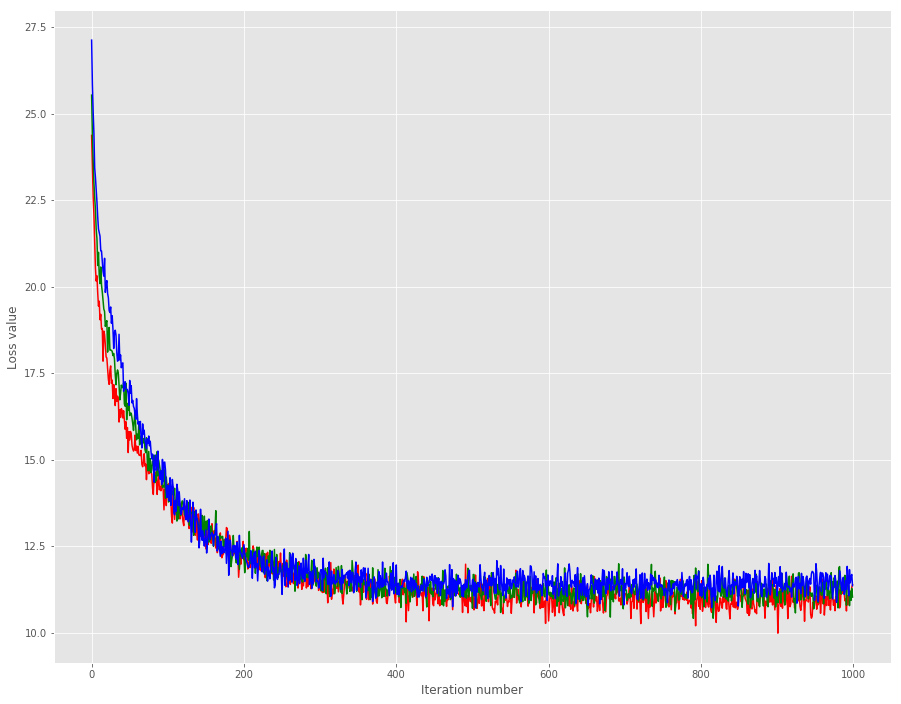

In [37]:
# Проверяем полученную реализацию.

rates = ([1e-7])
regs = ([2e4,2.5e4,3e4])
cr = (['r','g','b','c','y','m'])
N = 1000
loss_hist= [ [0]*N for _ in rates]

ci = 0
for li, lrate in enumerate(rates) :
    for ri, reg in enumerate(regs) :
        tic = time.time()
        svm = SVM(1000)
        ls = svm.train(x_train, y_train, N, lrate, reg, False)
        loss_hist[li] = ls
        toc = time.time()
        print('%d That took %fs' % (svm.Iters, toc - tic))
        plt.plot(loss_hist[li],cr[ci])
        ci+=1
        #plt.annotate( str(lrate), xy=(N/2,ls[N//2]), xytext=(N/2+ls*2, ls[0]*2),
        #       arrowprops=dict(facecolor='black', shrink=0.05)            )
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [65]:
print(np.array(loss_hist).shape)

(3, 1000, 1)


In [66]:

# Теперь вычислим точность на тренировочном и тестовом множествах
y_train_pred = svm.predict(x_train)
print('xxx %a : \n%a ' % (y_train_pred.shape, y_train-y_train_pred))
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(x_test)
print('validation accuracy: %f' % (np.mean(y_test == y_val_pred), ))

xxx (50000, 10) : 
array([[ 7.38425303,  5.91567197,  6.46594447, ...,  5.63582512,
         7.46226839,  6.67269983],
       [ 8.92793259,  8.00253681,  9.29866176, ...,  9.65023385,
         8.05629204,  8.74005313],
       [ 8.29438799,  8.56490678,  9.55310397, ...,  9.44705342,
         7.8364319 ,  7.19480228],
       ..., 
       [ 7.92496185,  8.09173417,  9.49950697, ...,  9.78261874,
         7.42513424,  6.97239911],
       [-0.19769965,  1.03514963,  1.00608248, ...,  1.21866709,
        -0.6558954 ,  0.14405063],
       [ 0.88918497,  0.93427434,  1.16967574, ...,  0.81283352,
         0.9139482 ,  0.25057731]]) 
training accuracy: 0.000000
validation accuracy: 0.000000


In [38]:
def plot_weights(best_svm):
    w = best_svm.W[:,:-1] # strip out the bias
    w = w.reshape(10, 32, 32, 3)
    w_min, w_max = np.min(w), np.max(w)
    classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    for i in range(10):
        plt.subplot(2, 5, i + 1)

        # Rescale the weights to be between 0 and 255
        wimg = 255.0 * (w[i, :, :, :].squeeze() - w_min) / (w_max - w_min)
        plt.imshow(wimg.astype('uint8'))
        plt.axis('off')
        plt.title(classes[i])

**Задача 3:** Подберите при помощи поиска по сетке наулучшие параметры learning rate и regularization coefficient. Для полученной модели вызовите функцию plot_weights(best_svm). Впишите свой код под этой ячейкой.

1200 That took 1882.365149s


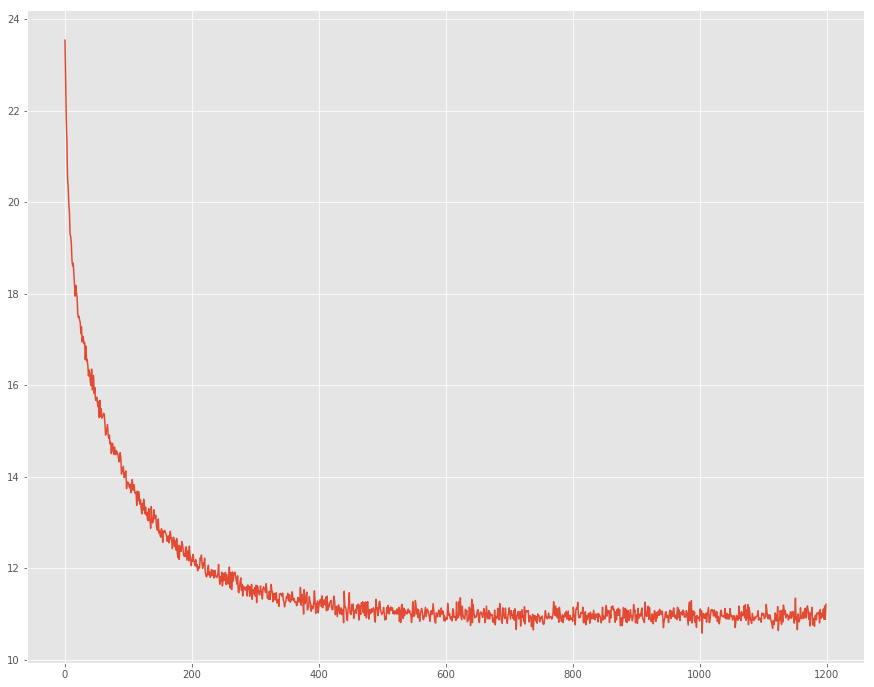

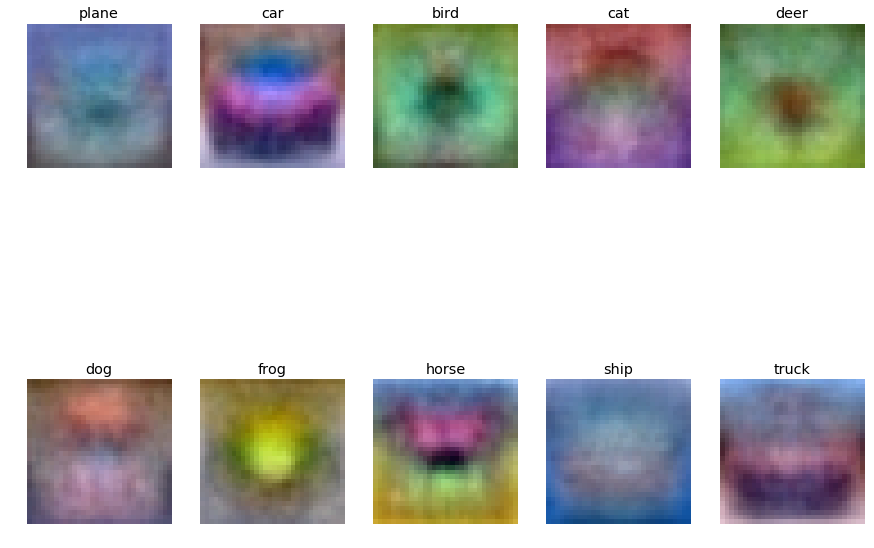

In [42]:
tic = time.time()
svm = SVM(5000)
loss_hist = svm.train(x_train, y_train, 1200, 1e-7, 2e4, False)
toc = time.time()
print('%d That took %fs' % (svm.Iters, toc - tic))
plt.plot(loss_hist)
plt.show()
plot_weights(svm)

**Задача 4:** О чём говорят полученные изображения? Какие выводы мы можем сделать? Впишите ответ в поле ниже

1-ого слоя недостаточно для решения задачи классификации 

**Задача 5:** Повторим упражнение для cross entropy loss

In [43]:
import math as m

def softmax(X):
    evals = [ m.exp(x) for x in X]
    s = sum(evals)
    return [z/s for z in evals]

def crossentropy_loss(W, X, y, reg):
    """
    Cross entropy loss function
   Inputs:
    - W: Матрица весов
    - X: Данные
    - y: Целевой признак
    - reg: (float) Коэффициент регуляризации
    Returns:
    a tuple:
    - loss (одно число)
    - градиент по W
    """
    
    # Впишите свой код на место заглушки
    loss = 0
    # cause of regulation member in loss function
    dW = np.zeros(W.shape)
    
    (N,n) = X.shape
    
    # get predicted for all X  
    Z = np.array([ softmax(np.dot(W,x)) for x in X])
    # select only True probability components from each softmax(W*x)
    lz = np.array( [ np.log(Z[i,yi]) for i,yi in enumerate(y)] )
    #print('lz: %a, losses: %a' % (lz.shape, lz[:10]))
    #print('y0:',y.shape)
    #print('yy[0]', yy[0])
    
    loss = -sum(lz) / N + reg * np.dot(W.flat,W.flat) 
    
    (K,m) = dW.shape
        
    for i, yi in enumerate(y) :
        dW[yi] += X[i]
    
        for k in range(K) :
            dW[k] -= X[i]*Z[i,k]

    dW /= -N
    dW += 2*reg*np.array(W)
    
    return loss, dW

In [44]:
# Грубая проверка, значения должны быть близки к -log(0.1).
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001
REG = 5e-5

loss1, grad1 = crossentropy_loss(svm.W, x_train, y_train, 0)
print('loss: %f : p(i)=%f' % (loss1, m.exp(-loss1)))
print('sanity check: %f' % (-np.log(0.1)))

loss: 1.823397 : p(i)=0.161476
sanity check: 2.302585


**Задача 6:** Кстати, почему такая проверка справедлива? Объясните

Так как на нетренированном массиве W параметров значения 
$p_{pred}^i = softmax( W  X_i) $
распределены равновероятно по множеству 10-ти классов  и коэффициент регуляризации R=0, поэтому 
$ L =  - \frac{1}{N} \sum \log( p_{pred}^i ) 
\leq -\log \sum \frac{y_{pred}^i}{N} 
\approx  -\log \frac{N \bar {p}} {N}  $
,где  $\bar {p} = \frac{1}{10}$

In [60]:
# Заполняем матрицу весов W случайным образом
W = np.random.randn(10, 3073) * 0.0001

# Вычисляем значение функции потерь и её градиент для W.
loss, grad = crossentropy_loss(W, x_test, y_test, 0.0)
f = lambda w: crossentropy_loss(w, x_test, y_test, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

print('now with REG=%f', 5e1)
loss, grad = crossentropy_loss(W, x_test, y_test, 5e1)
f = lambda w: crossentropy_loss(w, x_test, y_test, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -4.300139 analytic: -4.300139, relative error: 6.127477e-09
numerical: 1.716479 analytic: 1.716479, relative error: 4.655021e-08
numerical: 1.891663 analytic: 1.891662, relative error: 4.096040e-08
numerical: 0.655886 analytic: 0.655886, relative error: 9.000353e-09
numerical: -0.203964 analytic: -0.203964, relative error: 9.571471e-08
numerical: 0.770408 analytic: 0.770408, relative error: 6.226480e-08
numerical: -1.421576 analytic: -1.421576, relative error: 1.012137e-08
numerical: 0.553679 analytic: 0.553679, relative error: 6.623734e-08
numerical: -2.260451 analytic: -2.260451, relative error: 3.512726e-09
numerical: 3.864940 analytic: 3.864940, relative error: 4.968555e-09
numerical: -0.139433 analytic: -0.139433, relative error: 4.320451e-08
numerical: 0.858858 analytic: 0.858858, relative error: 1.643028e-08
numerical: 1.516789 analytic: 1.516789, relative error: 5.370239e-08
numerical: 0.317212 analytic: 0.317212, relative error: 1.071948e-07
numerical: 1.389387 anal